In [11]:
import pandas as pd
import datetime
import pytz 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error

In [2]:
def dateparse (time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

bitcoin = pd.read_csv(r"C:\Users\xianj\Desktop\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=[0], date_parser=dateparse)
bitcoin

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 02:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 02:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 02:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 02:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 02:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 19:56:00+00:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 19:57:00+00:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 19:58:00+00:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 19:59:00+00:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [3]:

bitcoin['Timestamp'] = bitcoin['Timestamp'].dt.tz_localize(None)
bitcoin = bitcoin.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
bitcoin = bitcoin.set_index('Timestamp')
bitcoin = bitcoin[['Close']]
bitcoin['Close'] = bitcoin['Close'].fillna(method='ffill')

In [14]:
bitcoin

,Close
Timestamp,
2011-12-31 02:00:00,4.39
2011-12-31 03:00:00,4.39
2011-12-31 04:00:00,4.39
2011-12-31 05:00:00,4.39
2011-12-31 06:00:00,4.39
...,...
2021-03-30 16:00:00,59037.79
2021-03-30 17:00:00,58591.06
2021-03-30 18:00:00,58762.56


In [4]:

splitdate = '2018-12-17'
predate = '2020-04-01'
bitcoin_train = bitcoin.loc[bitcoin.index > splitdate]
bitcoin_train = bitcoin_train.loc[bitcoin_train.index <= predate]
bitcoin_test = bitcoin.loc[bitcoin.index > predate]

training_set = bitcoin_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

In [16]:
print(bitcoin_train)
print(training_set)

                       Close
Timestamp                   
2018-12-17 01:00:00  3209.65
2018-12-17 02:00:00  3217.56
2018-12-17 03:00:00  3246.28
2018-12-17 04:00:00  3232.59
2018-12-17 05:00:00  3233.32
...                      ...
2020-03-31 20:00:00  6427.83
2020-03-31 21:00:00  6307.14
2020-03-31 22:00:00  6295.51
2020-03-31 23:00:00  6324.16
2020-04-01 00:00:00  6380.47

[11304 rows x 1 columns]
[[0.        ]
 [0.00074562]
 [0.00345285]
 ...
 [0.29088177]
 [0.2935824 ]
 [0.29889034]]


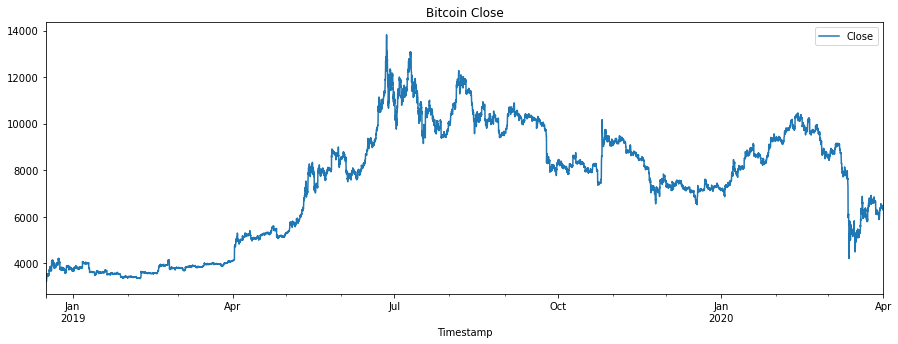

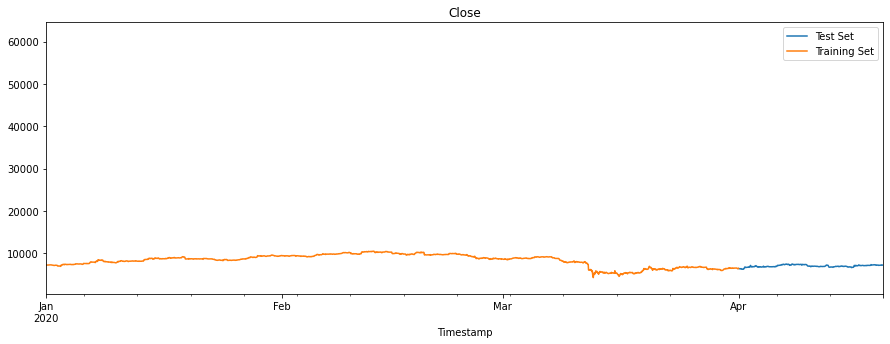

In [5]:

scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
Y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
bitcoin_train.plot(style='', figsize=(15,5), title='Bitcoin Close')
bitcoin_test.rename(columns={'Close':'Test Set'}).join(bitcoin_train.rename(columns={'Close': 'Training Set'}), how='outer').plot(figsize=(15,5), title='Close', style='')
plt.xlim('2020-01-01', '2020-04-20')
plt.legend()
plt.show()

Establish the LSTM model and set the parameter values: the activation function of the gate is the sigmoid function, the number of network nodes of the LSTM is set to 240, batch_size represents the number of gradient descent calculation parameters, if there are too many, the calculation speed will be slow, and the number will be too small. Lead to poor convergence effect. epochs is the training algebra.

In [6]:

model = Sequential()
model.add(LSTM(240, activation='sigmoid', input_shape=(1,1)))
model.add(Dropout(0.2)) 
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error') 
model.fit(X_train, Y_train, epochs=100, batch_size=50, verbose=2)
print(model.summary())

Epoch 1/100
227/227 - 4s - loss: 0.0643
Epoch 2/100
227/227 - 1s - loss: 0.0318
Epoch 3/100
227/227 - 1s - loss: 0.0197
Epoch 4/100
227/227 - 1s - loss: 0.0143
Epoch 5/100
227/227 - 1s - loss: 0.0109
Epoch 6/100
227/227 - 1s - loss: 0.0086
Epoch 7/100
227/227 - 1s - loss: 0.0071
Epoch 8/100
227/227 - 1s - loss: 0.0061
Epoch 9/100
227/227 - 1s - loss: 0.0053
Epoch 10/100
227/227 - 1s - loss: 0.0048
Epoch 11/100
227/227 - 1s - loss: 0.0043
Epoch 12/100
227/227 - 1s - loss: 0.0039
Epoch 13/100
227/227 - 1s - loss: 0.0036
Epoch 14/100
227/227 - 1s - loss: 0.0034
Epoch 15/100
227/227 - 1s - loss: 0.0031
Epoch 16/100
227/227 - 1s - loss: 0.0030
Epoch 17/100
227/227 - 1s - loss: 0.0028
Epoch 18/100
227/227 - 1s - loss: 0.0027
Epoch 19/100
227/227 - 1s - loss: 0.0025
Epoch 20/100
227/227 - 1s - loss: 0.0025
Epoch 21/100
227/227 - 1s - loss: 0.0023
Epoch 22/100
227/227 - 1s - loss: 0.0022
Epoch 23/100
227/227 - 1s - loss: 0.0021
Epoch 24/100
227/227 - 1s - loss: 0.0020
Epoch 25/100
227/227 - 1s

In [7]:
#预测
test_set = bitcoin_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
pred = model.predict(inputs)
pred = scaler.inverse_transform(pred)
bitcoin_test['Prediction'] = pred
bitcoin_all = pd.concat([bitcoin_test, bitcoin_train], sort=False)

<ipython-input-7-19f48ae5f684>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_test['Prediction'] = pred


In [17]:
test_set

array([[ 6353.55],
       [ 6303.17],
       [ 6302.8 ],
       ...,
       [58762.56],
       [58657.09],
       [58778.18]])

In [8]:

final_data = bitcoin_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Prediction': 'LSTM'})
final_data = final_data[['Timestamp', 'Close', 'LSTM']]
final_data

,Timestamp,Close,LSTM
0,2020-04-01 01:00:00,6353.55,6256.395508
1,2020-04-01 02:00:00,6303.17,6206.706543
2,2020-04-01 03:00:00,6302.80,6206.341309
3,2020-04-01 04:00:00,6331.46,6234.612305
4,2020-04-01 05:00:00,6320.04,6223.348145
...,...,...,...
20031,2020-03-31 20:00:00,6427.83,NaN
20032,2020-03-31 21:00:00,6307.14,NaN
20033,2020-03-31 22:00:00,6295.51,NaN
20034,2020-03-31 23:00:00,6324.16,NaN


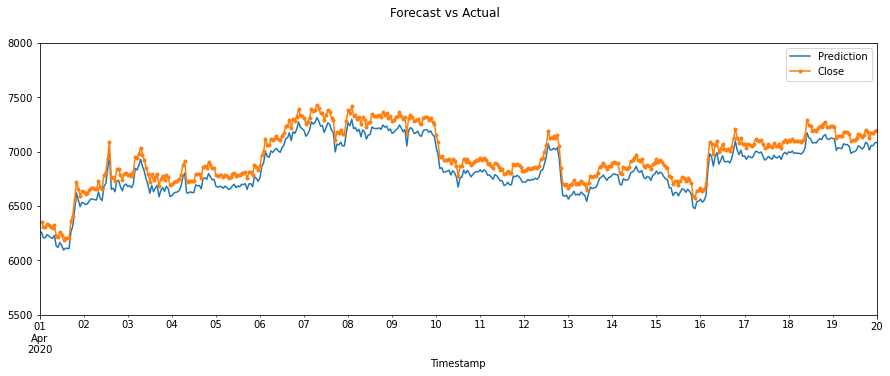

In [9]:
#画出与真实值的比较图像
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
bitcoin_test[['Prediction','Close']].plot(ax=ax, style=['-', '.-'])
ax.set_xbound(lower='2020-04-01', upper='2020-04-20')
ax.set_ylim(5500, 8000)
plt.suptitle('Forecast vs Actual')
plt.show()


In [13]:
PreSquE = mean_squared_error(y_true=bitcoin_test['Close'], y_pred=bitcoin_test['Prediction'])
PreAbE = mean_absolute_error(y_true=bitcoin_test['Close'], y_pred=bitcoin_test['Prediction'])
preSquLogE = mean_squared_log_error(y_true=bitcoin_test['Close'], y_pred=bitcoin_test['Prediction'])

print(PreSquE, PreAbE,preSquLogE)


195175809.6307867 7119.7434797901215 0.2005265976023196
